In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [5]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 5

# Dataset reading

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# モデルチェックポイントのコールバック (Model Checkpoint Callback)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    "model/keypoint_classifier/keypoint_classifier.keras",  # Change extension to .keras
    verbose=1, 
    save_weights_only=False
)

# 早期打ち切り用コールバック (Early Stopping Callback)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2780 - loss: 1.5995   
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2821 - loss: 1.5919 - val_accuracy: 0.3298 - val_loss: 1.4694
Epoch 2/1000
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3479 - loss: 1.4850 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3505 - loss: 1.4809 - val_accuracy: 0.4589 - val_loss: 1.3725
Epoch 3/1000
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.3666 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4054 - loss: 1.3652 - val_accuracy: 0.4729 - val_loss: 1.2704
Epoch 4/1000
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4231 - loss: 1.3050 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ke

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0.2522 


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[0.00333847 0.9819949  0.01466659]
1


# Confusion matrix

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


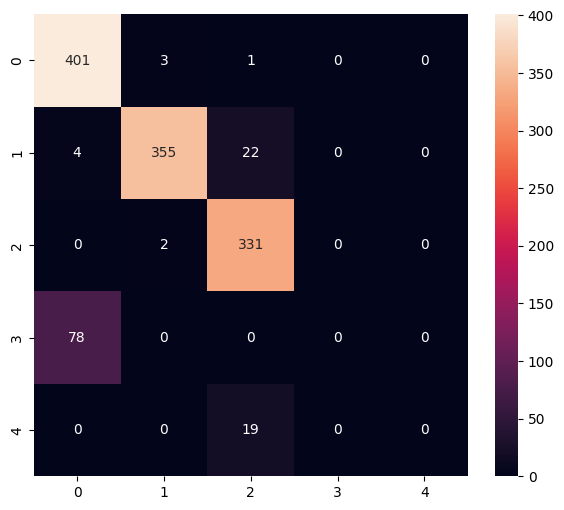

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       405
           1       0.99      0.93      0.96       381
           2       0.89      0.99      0.94       333
           3       0.00      0.00      0.00        78
           4       0.00      0.00      0.00        19

    accuracy                           0.89      1216
   macro avg       0.54      0.58      0.56      1216
weighted avg       0.83      0.89      0.86      1216



d:\krish\Documents\UBC_year_4\ELEC_391\computer_opencv_stuff\RealTimeObjectDetection\hand-gesture-recognition-mediapipe\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\krish\Documents\UBC_year_4\ELEC_391\computer_opencv_stuff\RealTimeObjectDetection\hand-gesture-recognition-mediapipe\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\krish\Documents\UBC_year_4\ELEC_391\computer_opencv_stuff\RealTimeObjectDetection\hand-gesture-recognition-mediapipe\.conda\lib\site-packages\sklearn\met

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\krish\AppData\Local\Temp\tmpmnchv8mz\assets


INFO:tensorflow:Assets written to: C:\Users\krish\AppData\Local\Temp\tmpmnchv8mz\assets


Saved artifact at 'C:\Users\krish\AppData\Local\Temp\tmpmnchv8mz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2477190788400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2477190683408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2477233282160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2477233278992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2477233287792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2477233285856: TensorSpec(shape=(), dtype=tf.resource, name=None)


6504

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

d:\krish\Documents\UBC_year_4\ELEC_391\computer_opencv_stuff\RealTimeObjectDetection\hand-gesture-recognition-mediapipe\.conda\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.06 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00333847 0.9819949  0.01466658]
1
